# Using pyoptsparse

opting siff

In [1]:
import pyoptsparse
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.sparse
import femGTopo
import femRandInput

seed = 1
femRandInput.set_seed(seed)


/home/harry/anaconda3/envs/DL/lib/python3.9/site-packages/pyoptsparse/pyOpt_MPI.py:68: UserWarning: mpi4py could not be imported. mpi4py is required to use the parallel gradient analysis and parallel objective analysis for non-gradient based optimizers. Continuing using a dummy MPI module from pyOptSparse.
  warnings.warn(warn)


(0.54296875, 0.23828125, 0.05859375)
Generated Fix Bnd F[0.43] Iup[0.17] Ilo[0.02]
Generated Fix Bnd F[0.13] Iup[0.87] Ilo[0.87]
Valid Generation Bnd F[0.13] Iup[0.87] Ilo[0.87] ForceFrac[0.87]


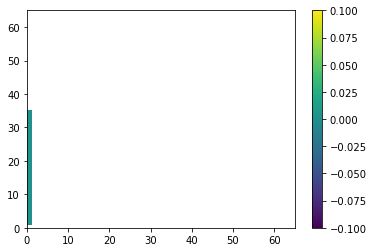

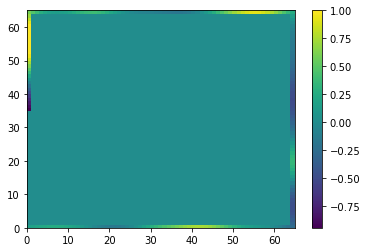

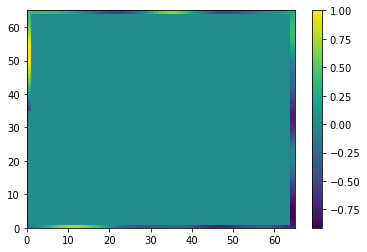

In [10]:

bndgen = femRandInput.randBoundaryFilter1DGen(passes=[32,48,64,80])
fixth = 0.3
fixflt=0.9
forcecent = 0.9
forceflt=0.8



bndgen.genNext()
fixData,fixIdx = bndgen.getBinaryMat(th=fixth,fltrange=fixflt)
fix = np.empty_like(fixData)
fix.fill(np.nan)
fix[fixIdx] = 0.0
print(bndgen.examineBinaryPortion())

bndgen.genNext()
fx = bndgen.getRandCutDownMat(fltrange=forceflt,datalo=-forcecent,datahi=forcecent)
bndgen.genNext()
fy = bndgen.getRandCutDownMat(fltrange=forceflt,datalo=-forcecent,datahi=forcecent)
fx[fixIdx] = 0.0
fy[fixIdx] = 0.0

bndgen.genNextBnd(fixflt=fixflt, fixth=fixth, forcecent=forcecent, forceflt=forceflt)



plt.figure()
plt.pcolor(bndgen.fix)
plt.colorbar()
plt.figure()
plt.pcolor(bndgen.fx)
plt.colorbar()
plt.figure()
plt.pcolor(bndgen.fy)
plt.colorbar()
fix = bndgen.fix
fx = bndgen.fx
fy = bndgen.fy



In [14]:

import numpy
Nx = 64
Ny = 64


vset = np.min([0.4 * bndgen.currentForceFraction,1])
MaxVM=100000

pVM = 1000

femF = femGTopo.isoGridFem2DOptFun(pVM, Nx, Ny, 1., 1.)
# fix = numpy.zeros((Ny + 1, Nx + 1))
# fx = numpy.zeros_like(fix)
# fy = numpy.zeros_like(fix)
# fix *= numpy.nan
# # fix[0:5, 0:50] = 0
# # fix[-1:-6:-1, 0:50] = 0
# fix[:,0] = 0
# # fx[-1, int(numpy.ceil(Nx*0.8)) :-1] = 1.0 / Nx
# # fx[:,-1] = 1.0 / Ny # right side
# fy[-1, :] = 1.0 / Nx
rho = numpy.ones((Ny, Nx)) * vset


femF.SetElemMat()
femF.setBCs(fix, fx, fy)
femF.AssembleKbLocal()
femF.Eval(rho,useVM = False)
femF.evalMax = 64
print(femF.PI_AB)

def objfuncs(xdict):
    rho = numpy.array(xdict["rho"]).reshape((Ny, Nx),order="C")
    femF.EvalVM(rho, useVM=True, storeRhoSeq = True)
    

    funcs = {}
    funcs["PI_AB"] = femF.PI_AB
    # funcs["PI_VM"] = femF.PI_VM
    funcs["vol"] = numpy.mean(rho)

    fail = False
    # print("===Call obj")
    return funcs, fail

def sensfuncs(xdict, fdict):
    sens = {}
    rho = numpy.array(xdict["rho"]).reshape((Ny, Nx),order="C")
    femF.EvalVMdiff(rho, useVM=False, storeRhoSeq = False)
    femF.FilterABdiff()
    
    # sens["PI_VM"] = {}
    # sens["PI_VM"]["rho"] = femF.dPI_VMdrho.reshape((1,Nx*Ny),order="C")

    sens["PI_AB"] = {}
    sens["PI_AB"]["rho"] = femF.dPI_ABdrho.reshape((1,Nx*Ny),order="C")
    # print("===Call sens")

    
    # plt.figure(2)
    # plt.clf()
    # plt.pcolor(opter.femF.xcm, opter.femF.ycm, opter.rho, shading='auto')
    # plt.colorbar()
    # plt.axis("equal")
    # f = plt.gcf()
    # f.set_size_inches(8,4)
    # display.display(plt.gcf())
    # display.clear_output(wait=True)

    return sens


opt = pyoptsparse.Optimization("FEMGTOPO",objFun=objfuncs)

opt.addVarGroup(
    "rho",
    nVars=Nx * Ny,
    varType="c",
    value=vset,
    lower=1e-3,
    upper=1.0,
    scale=1.0,
    offset=0.0,
)

opt.addConGroup(
    "vol",
    nCon=1,
    lower=vset,
    upper=vset,
    scale=1.0,
    linear=True,
    jac={"rho": numpy.ones((1, Nx * Ny))/(Nx*Ny)},
)

# opt.addConGroup(
#     "PI_VM",
#     nCon=1,
#     lower=None,
#     upper=MaxVM,
#     scale=1.0,
#     linear=False,
# )

opt.addObj(name="PI_AB" )

print(opt)

options = {}
options['print_level']=5
options['tol'] = 1e-5
options['max_iter'] = 128
opter = pyoptsparse.OPT("IPOPT", options = options)

6353953.362736516


Optimization Problem -- FEMGTOPO
    Objective Function: objfuncs


   Objectives
      Index  Name             Value
          0  PI_AB     0.000000E+00

   Variables (c - continuous, i - integer, d - discrete)
      Index  Name       Type      Lower Bound            Value      Upper Bound     Status
          0  rho_0         c     1.000000E-03     3.468750E-01     1.000000E+00           
          1  rho_1         c     1.000000E-03     3.468750E-01     1.000000E+00           
          2  rho_2         c     1.000000E-03     3.468750E-01     1.000000E+00           
          3  rho_3         c     1.000000E-03     3.468750E-01     1.000000E+00           
          4  rho_4         c     1.000000E-03     3.468750E-01     1.000000E+00           
          5  rho_5         c     1.000000E-03     3.468750E-01     1.000000E+00           
          6  rho_6         c     1.000000E-03     3.468750E-01     1.000000E+00           
          7  rho_7         c     1.00000

In [15]:
sol = opter(opt, sens=sensfuncs)


List of user-set options:

                                    Name   Value                used
                        file_print_level = 5                     yes
                   hessian_approximation = limited-memory        yes
                           linear_solver = mumps                 yes
                                max_iter = 128                   yes
                             output_file = IPOPT.out             yes
                             print_level = 5                     yes
                      print_user_options = yes                   yes
                                      sb = yes                   yes
                                     tol = 1e-05                 yes
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:     4096
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of va

64
v 0
756827.4030679218


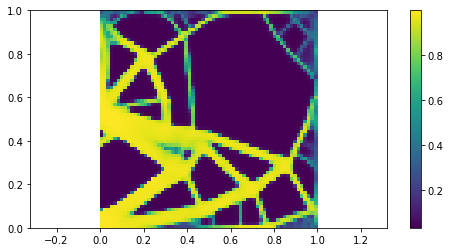

In [26]:
print(len(femF.rhoSeq))
print('v',sol.optInform['value'])
dvdict = sol.getDVs()
rho = dvdict['rho'].reshape((Ny,Nx))
plt.figure(2)
plt.clf()
ipeek = -1
rhoc = femF.rhoSeq[ipeek][0]
print(femF.rhoSeq[ipeek][3])
plt.pcolor(femF.xcm, femF.ycm, rhoc, shading='auto')
plt.colorbar()
plt.axis("equal")
f = plt.gcf()
f.set_size_inches(8,4)


In [4]:
import scipy.signal

import numpy

window = numpy.ones((3,3))
data = numpy.eye(10,10)
filt = scipy.signal.correlate2d(data,window, mode = 'same', boundary='symm')
filt

filt[:,-1:-5:-1]
# a = femF.dPI_VMdrho

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 2.],
       [0., 1., 2., 3.],
       [1., 2., 3., 2.],
       [3., 3., 2., 1.],
       [5., 3., 1., 0.]])